Démarrage de la simulation de trafic avec 170 véhicules initialement placés.
Configuration du réseau routier : Longueur de 2000 m, 3 voies.
Intervalle de temps de simulation par étape : 0.075 s.
Résolution graphique de la représentation routière : 10 m par caractère.
Conditions météorologiques actuelles : Normal.
Nombre d'étape de simulation 200
Animation désactivée.


Simulation en cours: 100%|██████████| 200/200 [00:14<00:00, 13.68it/s]



Simulation terminée.

--- Moyennes cumulées par voie (depuis le début de la simulation) ---
 Voie 0: Vitesse moyenne cumulée: 35.88 km/h
 Voie 1: Vitesse moyenne cumulée: 23.92 km/h
 Voie 2: Vitesse moyenne cumulée: 17.31 km/h



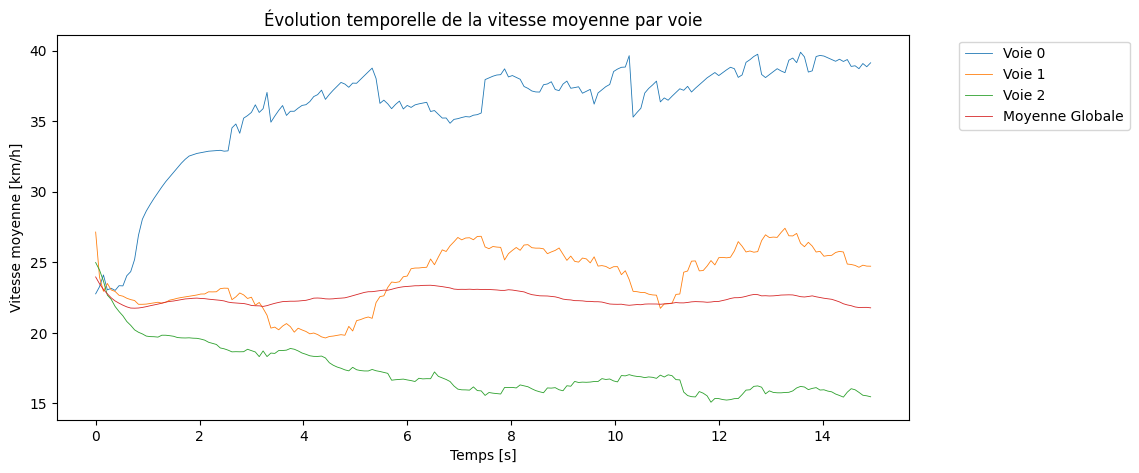

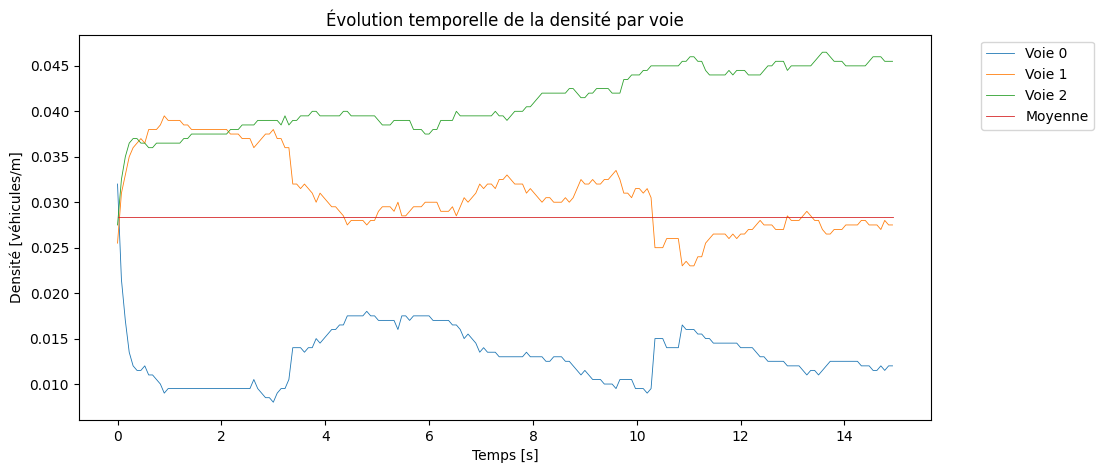

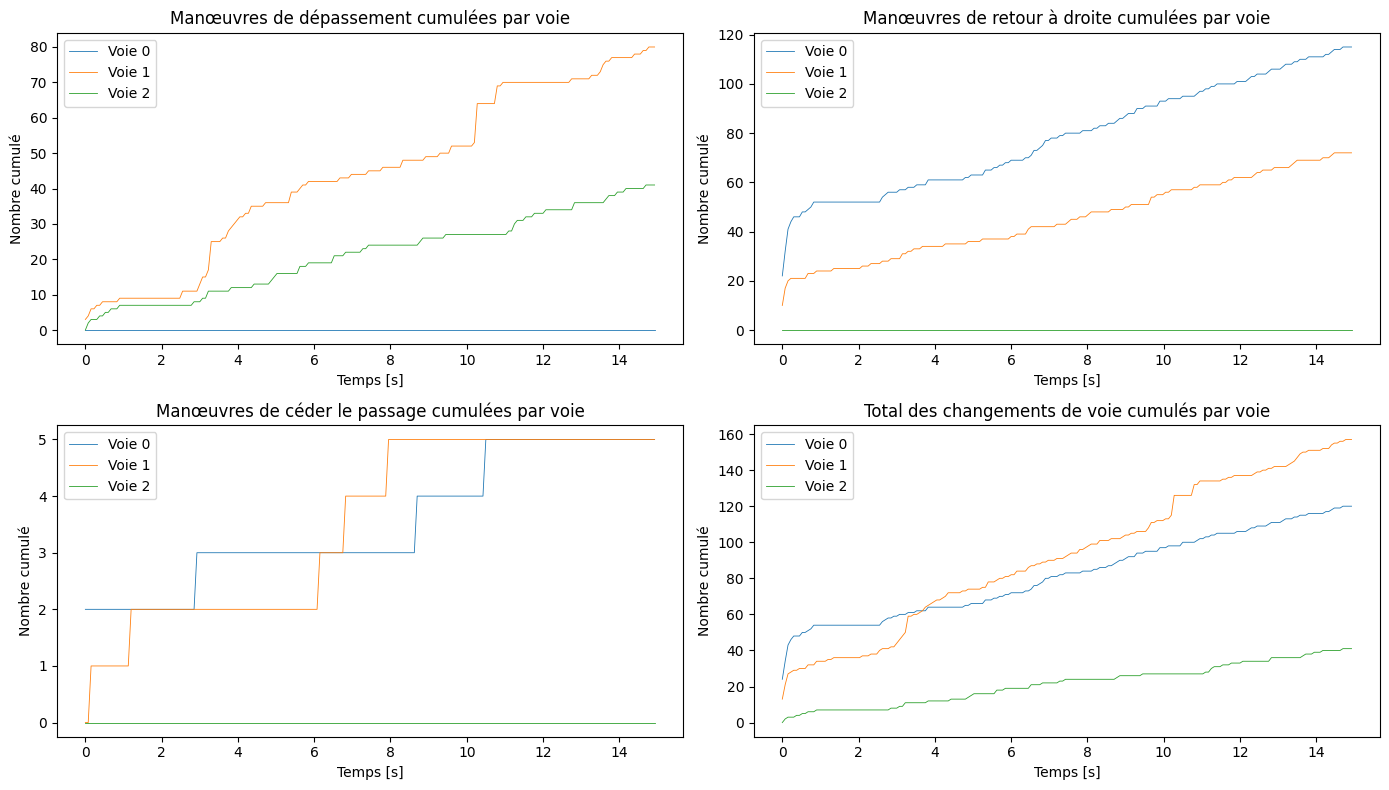

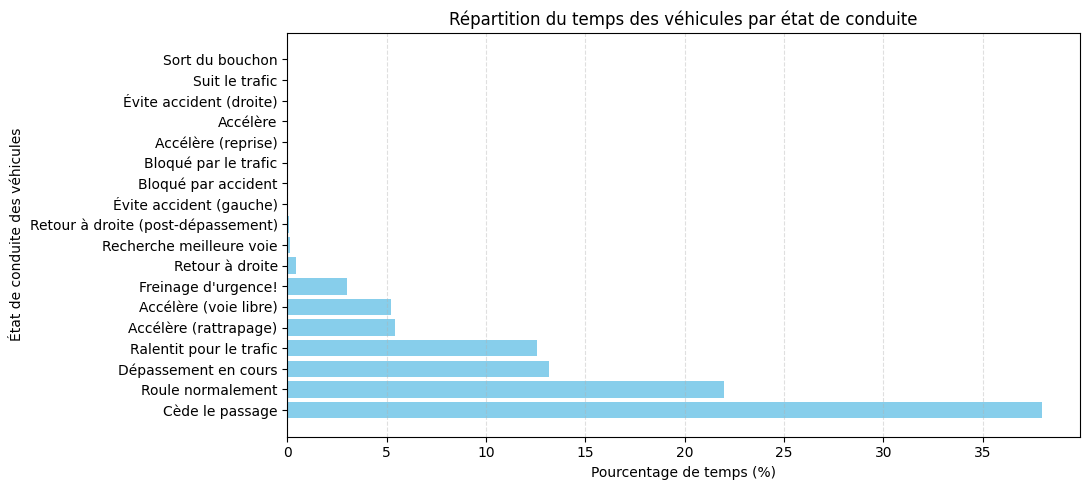

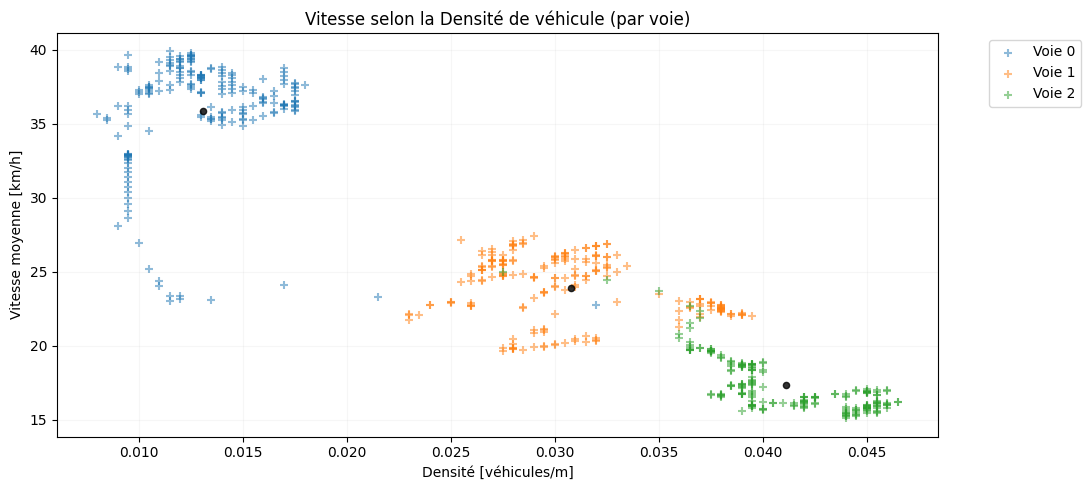

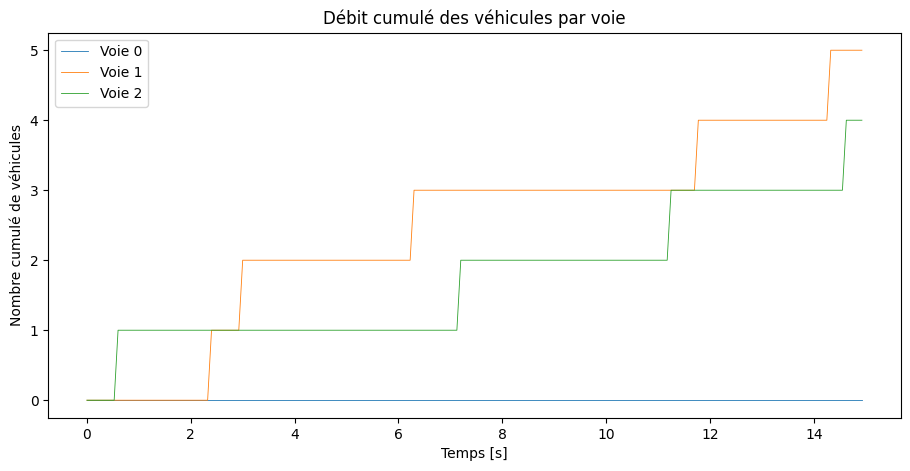

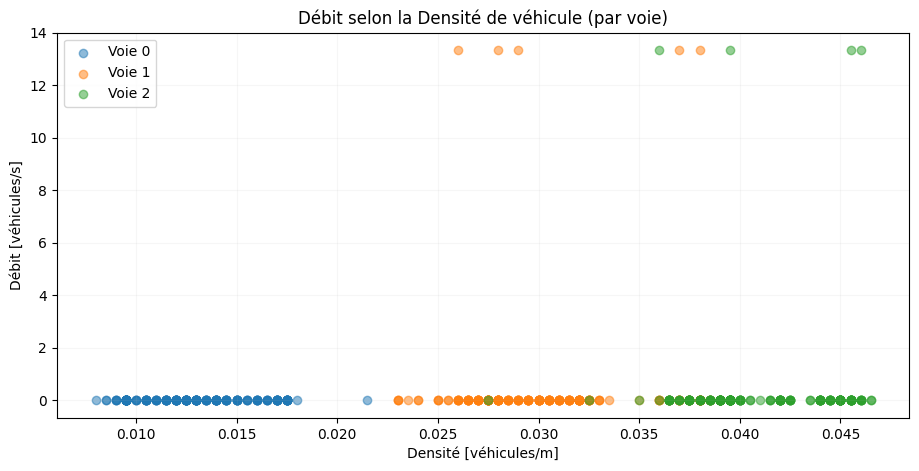


Aucun tour complet n'a été enregistré pour le graphique de temps de parcours.


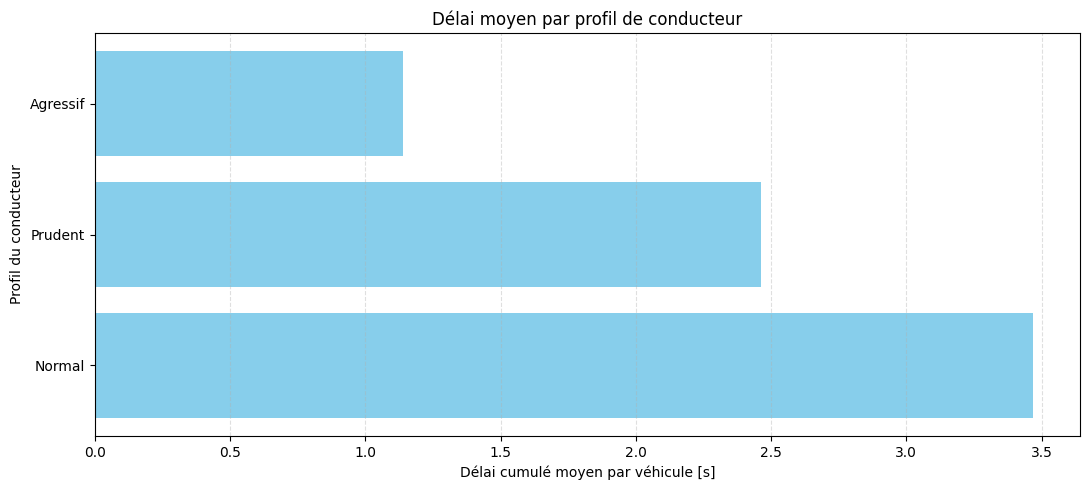

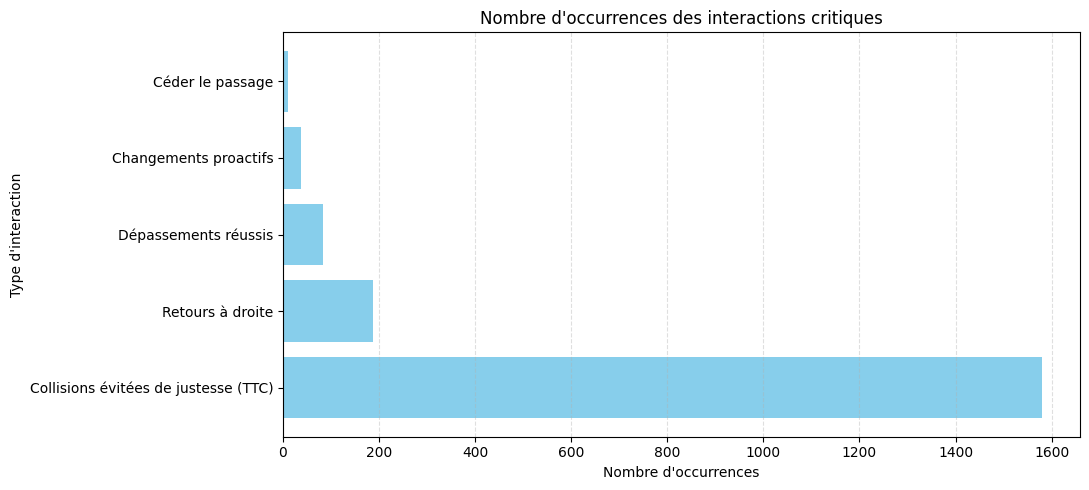

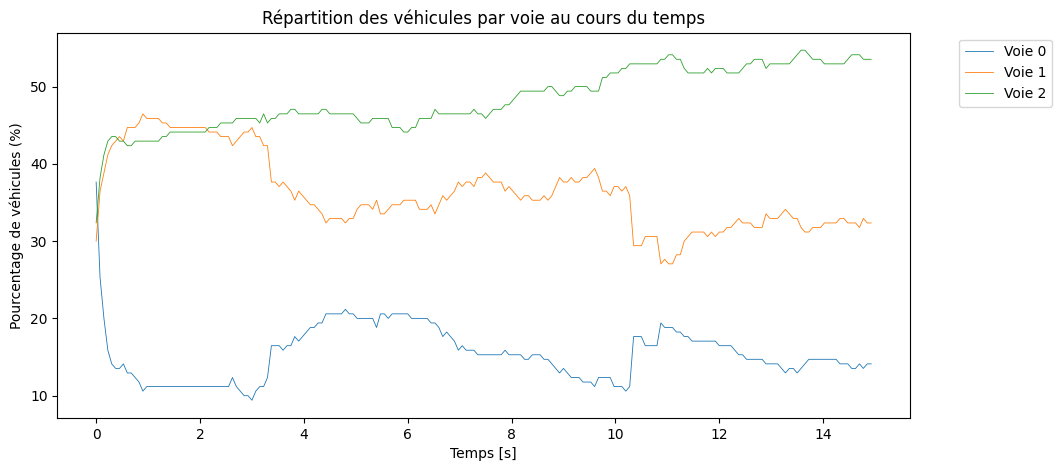

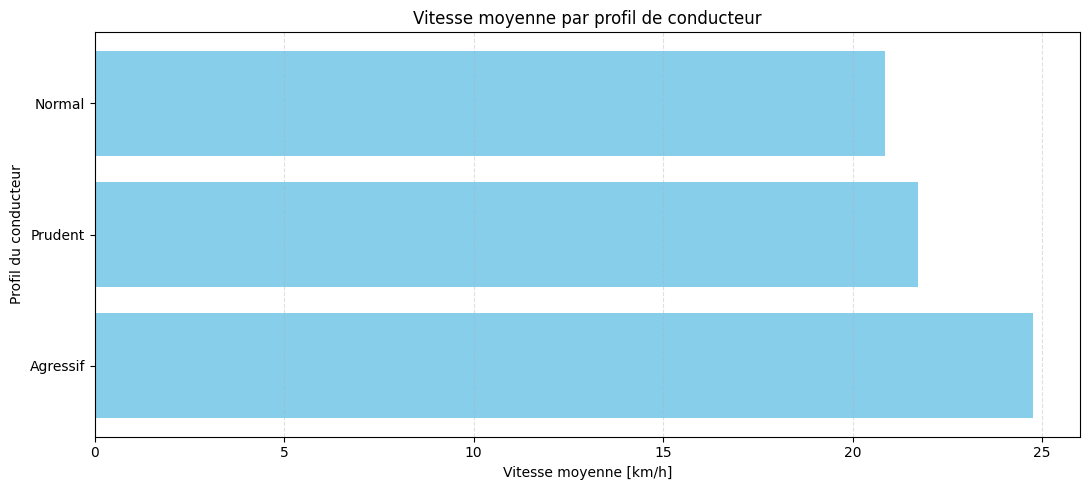

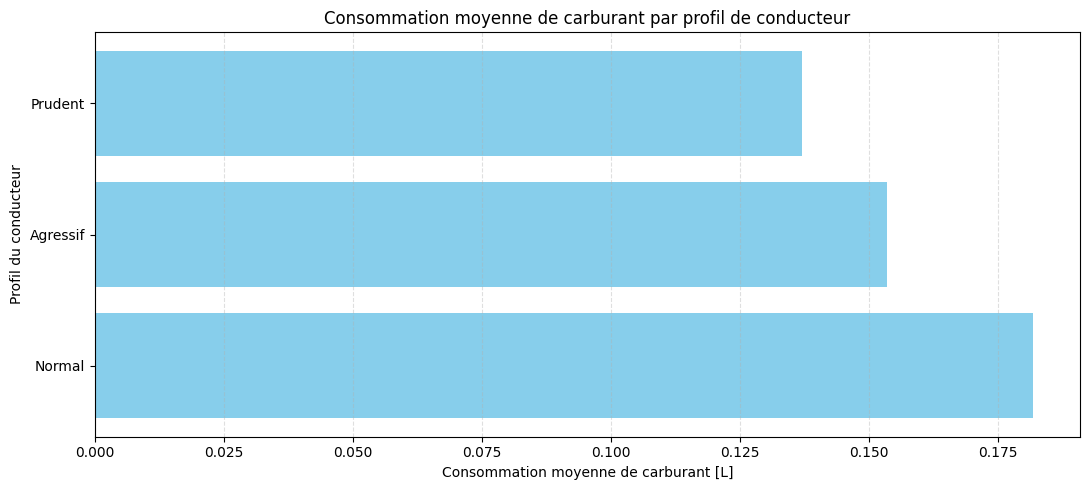

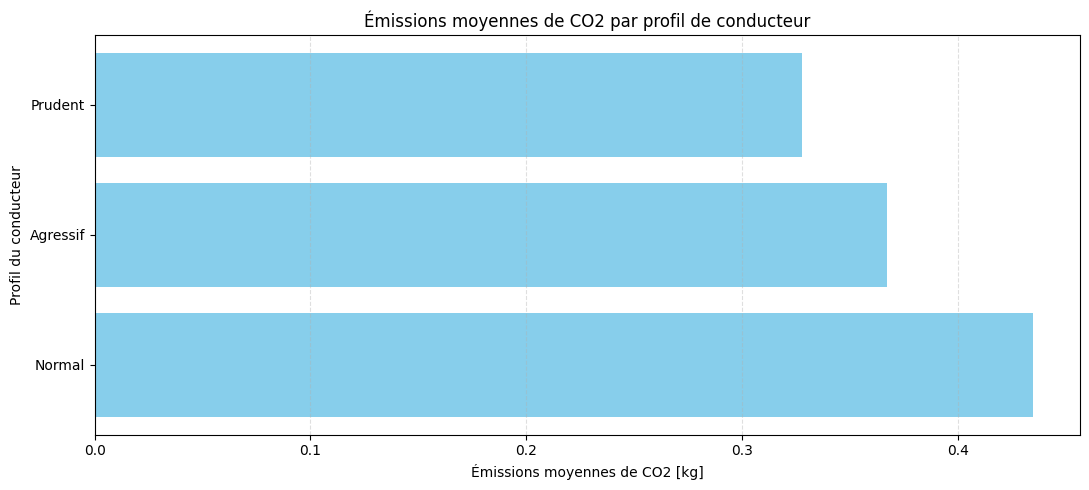


Aucune donnée de temps de parcours par profil de conducteur pour le boxplot.


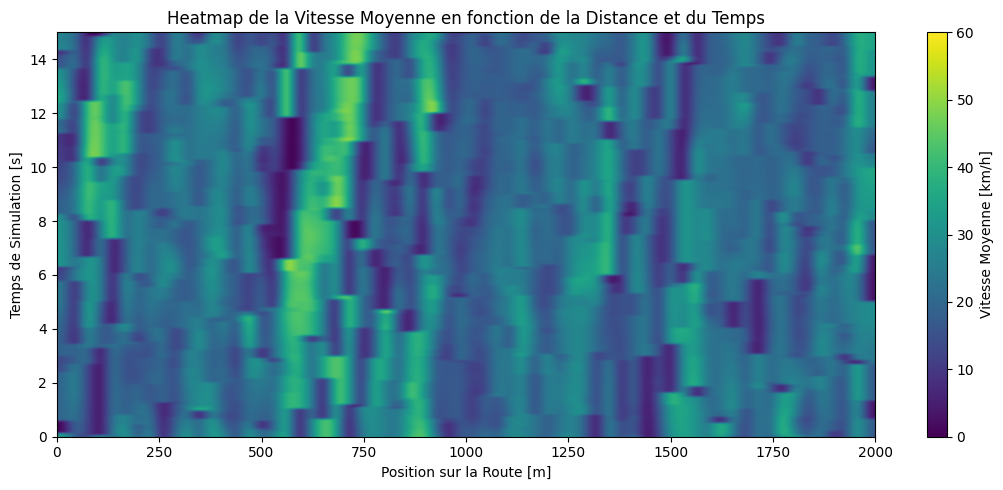

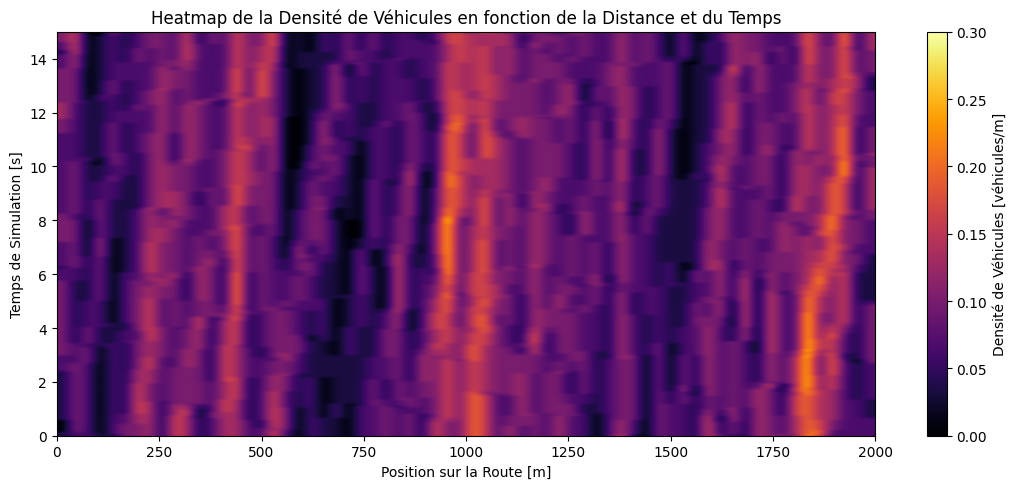

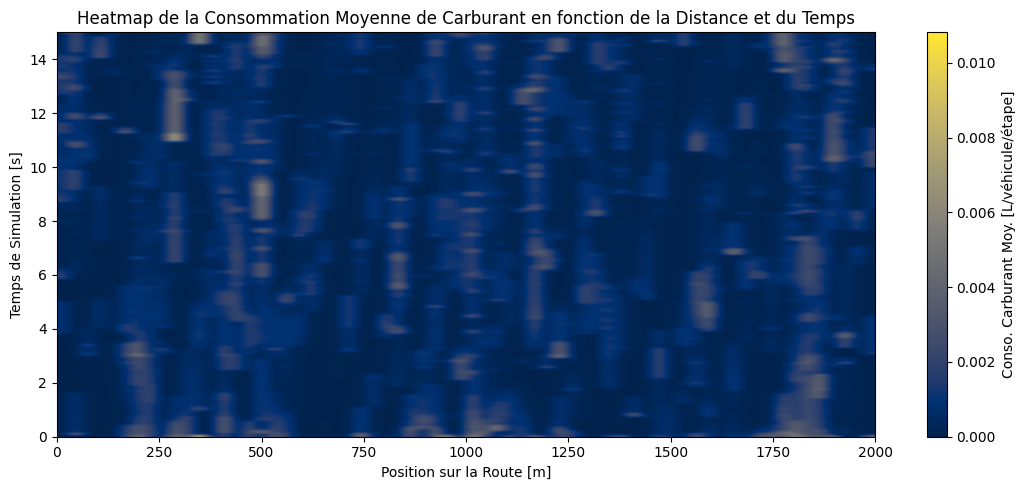

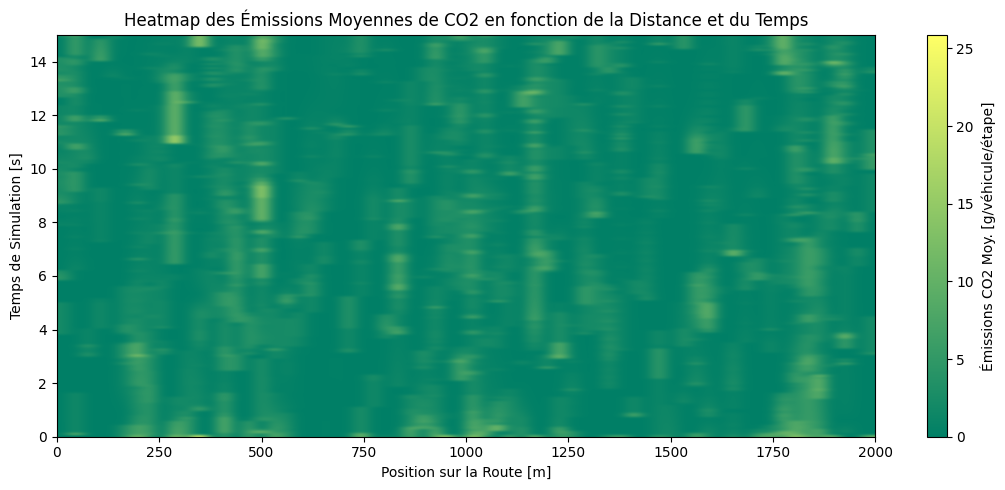

In [23]:
import random
import time
import os
import sys
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from tqdm import tqdm

try:
    from IPython.display import clear_output
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

# --- Constantes de la simulation ---
ROAD_LENGTH = 2000
NUM_LANES = 3
TIME_STEP = 0.075
KMH_TO_MS = 1000 / 3600
NUM_CARS_START = 170
SIMULATION_DURATION_STEPS = 200 # 210000

# Accidents: (position, lane, frame_to_appear)
ACCIDENT_LOCATIONS = []

# Météo
CURRENT_WEATHER = "normal" # Options: "normal", "beau temps", "haute chaleur", "pluie", "grosse pluie", "tempête", "grêle", "gèle", "neige", "brouillard"

# Paramètres des voitures
CAR_LENGTH = 5
SPEED_LIMIT_MIN_KMH = 0
SPEED_LIMIT_MAX_KMH = 50
FUEL_CONSUMPTION_L_PER_KM_CRUISE = 0.05
FUEL_CONSUMPTION_L_PER_MS2_ACCEL = 0.01
CO2_EMISSION_FACTOR_G_PER_L = 2392
TTC_WARNING_THRESHOLD = 1.5 

# Distances de sécurité
MIN_SAFE_GAP = 1.7
BLOCKING_DISTANCE_OVERTAKE_FACTOR_S = 1.0
LANE_CHANGE_SAFETY_FACTOR_FRONT_S = 0.5
LANE_CHANGE_SAFETY_FACTOR_BEHIND_S = 0.3

# Paramètres de comportement des vitesses
ACCELERATION_RATE_MS2 = 3.0
DECELERATION_RATE_MS2 = 6.0
OVERTAKE_SPEED_BOOST_KMH = 15
FOLLOWING_DISTANCE_IDEAL_S = 2.0
MIN_FOLLOWING_DISTANCE_CRITICAL = CAR_LENGTH + MIN_SAFE_GAP

# Distance de manœuvre de changement de voie
BASE_MANEUVER_DISTANCE = 30
SPEED_DEPENDENT_MANEUVER_FACTOR_S = 0.2

# Caractères utilisés pour afficher les IDs des voitures sur la route
DISPLAY_CHARS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWYZabcdefghijklmnopqrstuvwxyzΓΔΗΘΙΛΞΠΣΦΨΩαβγδεζηθικλμνξπρστυφψωБДЖЗИЙЛУФЦЧШЩЪЫЬЭЮЯабвгдежзийклмνπтуцчшщъыьэюя*$&#%ù@¤£§?êàöñç+"

# Résolution d'affichage de la route (mètres par caractère)
DISPLAY_RESOLUTION_METERS = 10

# Affichage ou non des status des voitures
CAR_STATUS = False

# Affichage ou non de l'animation/visualisation de la simulation
ANIMATION = False

# heatmap
ROAD_SEGMENT_SIZE = 30
NUM_ROAD_SEGMENTS = ROAD_LENGTH // ROAD_SEGMENT_SIZE

# Facteur de ralentissement de la simulation pour visualiser l'animation des voitures
WAIT_ANIM = 0

# Seuils de densité pour déterminer les conditions de trafic
TRAFFIC_DENSITY_THRESHOLD_HIGH = 1 / (CAR_LENGTH + MIN_SAFE_GAP) 
TRAFFIC_DENSITY_THRESHOLD_FLUID = TRAFFIC_DENSITY_THRESHOLD_HIGH * 0.2

# Probabilité de céder le passage en fonction du trafic
YIELD_LIKELIHOOD_HEAVY_TRAFFIC = 0.2
YIELD_LIKELIHOOD_NORMAL_TRAFFIC = 0.7

# Paramètres des profils de conducteurs
DRIVER_PROFILES = {
    "prudent": {
        "speed_limit_tolerance": 0.05,
        "acceleration_factor": 0.8,
        "deceleration_factor": 0.8,
        "following_distance_factor": 1.5,
        "lane_change_aggressiveness": 0.1,
        "return_right_propensity": 0.9,
        "reaction_time_range": (0.5, 1.0)
    },
    "normal": {
        "speed_limit_tolerance": 5,
        "acceleration_factor": 1.0,
        "deceleration_factor": 1.0,
        "following_distance_factor": 1.0,
        "lane_change_aggressiveness": 0.5,
        "return_right_propensity": 0.7,
        "reaction_time_range": (0.3, 0.7)
    },
    "agressif": {
        "speed_limit_tolerance": 10,
        "acceleration_factor": 1.2,
        "deceleration_factor": 1.2,
        "following_distance_factor": 0.7,
        "lane_change_aggressiveness": 0.9,
        "return_right_propensity": 0.3,
        "reaction_time_range": (0.1, 0.4)
    }
}

WEATHER_EFFECTS = {
    "beau temps": {
        "reaction_time_modifier": 1.0,
        "speed_limit_tolerance_modifier": 1.0,
        "acceleration_factor_modifier": 1.0,
        "deceleration_factor_modifier": 1.0,
        "following_distance_factor_modifier": 1.0,
        "lane_change_aggressiveness_modifier": 1.0,
        "return_right_propensity_modifier": 1.0
    },
    "haute chaleur": {
        "reaction_time_modifier": 1.05,
        "speed_limit_tolerance_modifier": 0.9,
        "acceleration_factor_modifier": 0.95,
        "deceleration_factor_modifier": 0.95,
        "following_distance_factor_modifier": 1.0,
        "lane_change_aggressiveness_modifier": 0.9,
        "return_right_propensity_modifier": 0.9
    },
    "pluie": {
        "reaction_time_modifier": 1.15,
        "speed_limit_tolerance_modifier": 0.8,
        "acceleration_factor_modifier": 0.85,
        "deceleration_factor_modifier": 0.85,
        "following_distance_factor_modifier": 1.2,
        "lane_change_aggressiveness_modifier": 0.6,
        "return_right_propensity_modifier": 0.7
    },
    "grosse pluie": {
        "reaction_time_modifier": 1.3,
        "speed_limit_tolerance_modifier": 0.6,
        "acceleration_factor_modifier": 0.7,
        "deceleration_factor_modifier": 0.7,
        "following_distance_factor_modifier": 1.5,
        "lane_change_aggressiveness_modifier": 0.3,
        "return_right_propensity_modifier": 0.5
    },
    "brouillard": {
        "reaction_time_modifier": 1.25,
        "speed_limit_tolerance_modifier": 0.7,
        "acceleration_factor_modifier": 0.8,
        "deceleration_factor_modifier": 0.85,
        "following_distance_factor_modifier": 1.6,
        "lane_change_aggressiveness_modifier": 0.4,
        "return_right_propensity_modifier": 0.8
    },
    "tempête": {
        "reaction_time_modifier": 1.5,
        "speed_limit_tolerance_modifier": 0.4,
        "acceleration_factor_modifier": 0.5,
        "deceleration_factor_modifier": 0.5,
        "following_distance_factor_modifier": 2.0,
        "lane_change_aggressiveness_modifier": 0.1,
        "return_right_propensity_modifier": 0.2
    },
    "grêle": {
        "reaction_time_modifier": 1.6,
        "speed_limit_tolerance_modifier": 0.3,
        "acceleration_factor_modifier": 0.4,
        "deceleration_factor_modifier": 0.4,
        "following_distance_factor_modifier": 2.5,
        "lane_change_aggressiveness_modifier": 0.05,
        "return_right_propensity_modifier": 0.1
    },
    "gèle": {
        "reaction_time_modifier": 1.4,
        "speed_limit_tolerance_modifier": 0.5,
        "acceleration_factor_modifier": 0.6,
        "deceleration_factor_modifier": 0.6,
        "following_distance_factor_modifier": 1.8,
        "lane_change_aggressiveness_modifier": 0.2,
        "return_right_propensity": 0.4
    },
    "neige": {
        "reaction_time_modifier": 1.3,
        "speed_limit_tolerance_modifier": 0.6,
        "acceleration_factor_modifier": 0.7,
        "deceleration_factor_modifier": 0.7,
        "following_distance_factor_modifier": 1.7,
        "lane_change_aggressiveness_modifier": 0.4,
        "return_right_propensity_modifier": 0.6
    }
}

# --- Classe Voiture ---
class Voiture:
    def __init__(self, id_voiture, position, vitesse_kmh, voie, length=CAR_LENGTH, is_accident=False):
        self.id = id_voiture
        self.position = position
        self._original_vitesse_ms = vitesse_kmh * KMH_TO_MS
        self.current_vitesse_ms = self._original_vitesse_ms
        self.voie = voie
        self.previous_voie = voie
        self.length = length
        self.is_overtaking = False
        self.is_yielding = False
        self.maneuver_start_position = -1
        self.maneuver_target_distance = -1
        self.status = "Roule normalement"
        self.has_just_overtaken = False
        self.last_crossed_finish_line_time = 0.0
        self.previous_status = "Initial"
        self.driver_profile = random.choice(list(DRIVER_PROFILES.keys()))
        self.blocked_time_counter = 0.0
        self.cumulative_delay_time = 0.0
        self.total_lane_changes = 0
        self.total_distance_travelled = 0.0
        self.lap_times = []
        self.cumulative_fuel_consumption = 0.0
        self.cumulative_co2_emissions = 0.0
        self.near_miss_count = 0

        self._next_vitesse_ms = None
        self._next_voie = None
        self._next_status = None
        self._calculated_acceleration_for_step = 0.0

        weather_impact = WEATHER_EFFECTS.get(CURRENT_WEATHER, WEATHER_EFFECTS["beau temps"])

        self.reaction_time = random.uniform(*DRIVER_PROFILES[self.driver_profile]["reaction_time_range"]) * weather_impact["reaction_time_modifier"]
        self.speed_limit_tolerance_ms = DRIVER_PROFILES[self.driver_profile]["speed_limit_tolerance"] * KMH_TO_MS * weather_impact["speed_limit_tolerance_modifier"]
        self.acceleration_rate_ms2 = ACCELERATION_RATE_MS2 * DRIVER_PROFILES[self.driver_profile]["acceleration_factor"] * weather_impact["acceleration_factor_modifier"]
        self.deceleration_rate_ms2 = DECELERATION_RATE_MS2 * DRIVER_PROFILES[self.driver_profile]["deceleration_factor"] * weather_impact["deceleration_factor_modifier"]
        self.following_distance_factor = DRIVER_PROFILES[self.driver_profile]["following_distance_factor"] * weather_impact["following_distance_factor_modifier"]
        self.lane_change_aggressiveness = DRIVER_PROFILES[self.driver_profile]["lane_change_aggressiveness"] * weather_impact["lane_change_aggressiveness_modifier"]
        self.return_right_propensity = DRIVER_PROFILES[self.driver_profile]["return_right_propensity"] * weather_impact["return_right_propensity_modifier"]
        
        self.reaction_time = max(0.01, self.reaction_time)
        self.speed_limit_tolerance_ms = max(0.0, self.speed_limit_tolerance_ms)
        self.acceleration_rate_ms2 = max(0.1, self.acceleration_rate_ms2)
        self.deceleration_rate_ms2 = max(0.1, self.deceleration_rate_ms2)
        self.following_distance_factor = max(0.5, self.following_distance_factor)
        self.lane_change_aggressiveness = max(0.0, min(1.0, self.lane_change_aggressiveness))
        self.return_right_propensity = max(0.0, min(1.0, self.return_right_propensity))

        self.original_lane_change_aggressiveness = self.lane_change_aggressiveness
        self.original_following_distance_factor = self.following_distance_factor
        
        self.is_accident = is_accident
        
        self.adaptation_rate = 0.005
        self.de_adaptation_rate = 0.002
        self.adaptation_threshold_seconds = 10.0
        
        if self.is_accident:
            self.current_vitesse_ms = 0.0
            self._original_vitesse_ms = 0.0
            self.status = "Accident"
            self.adaptation_rate = 0.0
            self.de_adaptation_rate = 0.0

    def __repr__(self):
        status_str = ""
        if self.is_overtaking:
            status_str = " (Dépassement)"
        elif self.is_yielding:
            status_str = " (Cède passage)"
        elif self.is_accident:
            status_str = " (Accident)"
        return (f"V(ID:{self.id}, Pos:{self.position:.2f}m, Vit:{self.current_vitesse_ms*3.6:.2f}km/h, "
                f"Voie:{self.voie}, Profil:{self.driver_profile}{status_str})")

# --- Fonctions utilitaires ---
def clear_screen():
    if IS_IPYTHON:
        clear_output(wait=True)
    else:
        os.system('cls' if os.name == 'nt' else 'clear')

def get_distance(pos1, pos2, road_length):
    distance = pos2 - pos1
    if distance < 0:
        distance += road_length
    return distance

def get_segments(pos, length, road_length):
    start = (pos - length + road_length) % road_length
    end = pos % road_length
    if start <= end:
        return [(start, end)]
    else:
        return [(start, road_length), (0, end)]

def do_segments_overlap(seg1, seg2, buffer):
    s1, e1 = seg1
    s2, e2 = seg2
    return not (e1 + buffer < s2 or e2 + buffer < s1)

def check_overlap_robust(pos1, len1, pos2, len2, road_length, buffer):
    segments1 = get_segments(pos1, len1, road_length)
    segments2 = get_segments(pos2, len2, road_length)

    for s1 in segments1:
        for s2 in segments2:
            if do_segments_overlap(s1, s2, buffer):
                return True
    return False

def is_lane_clear(current_car, target_lane, cars_list, road_length):
    dynamic_safe_front_zone = current_car.current_vitesse_ms * LANE_CHANGE_SAFETY_FACTOR_FRONT_S * current_car.following_distance_factor
    dynamic_safe_behind_zone = current_car.current_vitesse_ms * LANE_CHANGE_SAFETY_FACTOR_BEHIND_S * current_car.following_distance_factor

    for other_car_on_target_lane in cars_list:
        if other_car_on_target_lane.id == current_car.id:
            continue

        if other_car_on_target_lane.voie == target_lane:
            if check_overlap_robust(current_car.position, current_car.length, other_car_on_target_lane.position, other_car_on_target_lane.length, road_length, dynamic_safe_front_zone):
                return False
            if check_overlap_robust(other_car_on_target_lane.position, other_car_on_target_lane.length, current_car.position, current_car.length, road_length, dynamic_safe_behind_zone):
                return False

    return True

def is_space_clear_for_object(obj_pos, obj_lane, obj_length, cars_list, road_length, buffer=MIN_SAFE_GAP):
    for other_car in cars_list:
        if other_car.voie != obj_lane:
            continue
        
        if check_overlap_robust(obj_pos, obj_length, other_car.position, other_car.length, road_length, buffer):
            return False
            
    return True

def handle_obstruction_for_accident(target_pos, target_lane, voitures_list, road_length, accident_length=CAR_LENGTH, buffer=MIN_SAFE_GAP):
    obstructing_cars = []
    for car in voitures_list:
        if car.voie == target_lane and not car.is_accident:
            if not is_space_clear_for_object(target_pos, target_lane, accident_length, [car], road_length, buffer):
                obstructing_cars.append(car)

    if not obstructing_cars:
        return True

    for obstructing_car in obstructing_cars:
        print(f"AVERTISSEMENT: Voiture {obstructing_car.id} à {obstructing_car.position:.2f}m sur la voie {obstructing_car.voie} obstrue l'accident.")

        pushed_successfully = False
        potential_new_pos = (target_pos + accident_length + obstructing_car.length + buffer * 2) % road_length
        
        temp_cars_for_check = [c for c in voitures_list if c.id != obstructing_car.id]
        
        if is_space_clear_for_object(potential_new_pos, obstructing_car.voie, obstructing_car.length, temp_cars_for_check, road_length, buffer):
            obstructing_car.position = potential_new_pos
            print(f"DEBUG: Voiture {obstructing_car.id} poussée à {obstructing_car.position:.2f}m sur la même voie.")
            pushed_successfully = True
        
        if pushed_successfully:
            continue
            
        relocated = False
        max_relocation_attempts = 50
        for _ in range(max_relocation_attempts):
            random_pos = random.uniform(0, road_length)
            random_lane = random.randint(0, NUM_LANES - 1)
            if is_space_clear_for_object(random_pos, random_lane, obstructing_car.length, temp_cars_for_check, road_length, buffer):
                obstructing_car.position = random_pos
                obstructing_car.voie = random_lane
                print(f"DEBUG: Voiture {obstructing_car.id} déplacée aléatoirement à {random_pos:.2f}m sur la voie {random_lane}.")
                relocated = True
                break
        
        if relocated:
            continue

        print(f"AVERTISSEMENT: Voiture {obstructing_car.id} à {obstructing_car.position:.2f}m sur la voie {obstructing_car.voie} supprimée pour faire place à un accident.")
        voitures_list.remove(obstructing_car)

    return True

# --- Fonction principale de la simulation ---
def run_simulation():
    voitures = []
    
    next_available_id = NUM_CARS_START

    accidents_to_place_queue = []
    for acc_pos, acc_lane, acc_frame in ACCIDENT_LOCATIONS:
        if 0 <= acc_lane < NUM_LANES and 0 <= acc_pos < ROAD_LENGTH:
            accidents_to_place_queue.append({"pos": acc_pos, "lane": acc_lane, "frame": acc_frame, "id": next_available_id})
            next_available_id += 1
        else:
            print(f"Attention : Position d'accident ({acc_pos}m, voie {acc_lane}) hors des limites de la route. Cet accident ne sera pas planifié.")

    accidents_to_place_queue.sort(key=lambda x: x["frame"])
    
    for i in range(NUM_CARS_START):
        initial_position = random.uniform(0, ROAD_LENGTH)
        initial_speed_kmh = random.uniform(SPEED_LIMIT_MIN_KMH, SPEED_LIMIT_MAX_KMH)
        initial_lane = random.randint(0, NUM_LANES - 1)
        attempts = 0
        max_attempts = 100
        while attempts < max_attempts:
            if is_space_clear_for_object(initial_position, initial_lane, CAR_LENGTH, voitures, ROAD_LENGTH):
                voitures.append(Voiture(i, initial_position, initial_speed_kmh, initial_lane))
                break
            else:
                initial_position = random.uniform(0, ROAD_LENGTH)
                initial_lane = random.randint(0, NUM_LANES - 1)
                attempts += 1
        if attempts == max_attempts:
            print(f"AVERTISSEMENT: Impossible de placer la voiture {i} sans chevauchement après {max_attempts} tentatives. Ignorée.")

    print(f"Démarrage de la simulation de trafic avec {len(voitures)} véhicules initialement placés.")
    print(f"Configuration du réseau routier : Longueur de {ROAD_LENGTH} m, {NUM_LANES} voies.")
    print(f"Intervalle de temps de simulation par étape : {TIME_STEP} s.")
    print(f"Résolution graphique de la représentation routière : {DISPLAY_RESOLUTION_METERS} m par caractère.")
    print(f"Conditions météorologiques actuelles : {CURRENT_WEATHER.capitalize()}.")
    print(f"Nombre d'étape de simulation {SIMULATION_DURATION_STEPS}")

    if ANIMATION:
        time.sleep(2)
    else:
        print("Animation désactivée.")

    lane_speeds_history = {lane_idx: [] for lane_idx in range(NUM_LANES)}
    lane_densities_history = {lane_idx: [] for lane_idx in range(NUM_LANES)}
    overall_avg_speeds_history = []
    overall_densities_history = []

    cumulative_lane_change_counts_per_step = defaultdict(lambda: defaultdict(list))
    maneuver_types_for_plot = ["depassement", "retour_a_droite", "ceder_le_passage", "total"]
    for m_type in maneuver_types_for_plot:
        for l_idx in range(NUM_LANES):
            cumulative_lane_change_counts_per_step[m_type][l_idx] = []

    total_time_in_status = defaultdict(float)
    possible_statuses = set()
    for car in voitures:
        possible_statuses.add(car.status)
    possible_statuses.update(["Roule normalement", "Dépassement en cours", "Freinage d'urgence!", 
                              "Ralentit pour le trafic", "Retour à droite", "Cède le passage", 
                              "Accélère", "Accélère (voie libre)", "Sort du bouchon", "Accélère (reprise)", "Suit le trafic", "Bloqué par le trafic", "Recherche meilleure voie", "Évite accident (gauche)", "Évite accident (droite)", "Bloqué par accident"])
    for status_key in possible_statuses:
        total_time_in_status[status_key] = 0.0

    lane_throughput_history_per_lane = {lane_idx: [] for lane_idx in range(NUM_LANES)}
    
    completed_lap_times = []

    critical_interaction_counts = defaultdict(int)

    lane_usage_percentage_history = {lane_idx: [] for lane_idx in range(NUM_LANES)}

    speed_heatmap_data = np.zeros((SIMULATION_DURATION_STEPS, NUM_ROAD_SEGMENTS))
    density_heatmap_data = np.zeros((SIMULATION_DURATION_STEPS, NUM_ROAD_SEGMENTS))
    fuel_consumption_heatmap_data = np.zeros((SIMULATION_DURATION_STEPS, NUM_ROAD_SEGMENTS))
    co2_emissions_heatmap_data = np.zeros((SIMULATION_DURATION_STEPS, NUM_ROAD_SEGMENTS))

    if ANIMATION:
        simulation_steps_iterator = range(SIMULATION_DURATION_STEPS)
    else:
        simulation_steps_iterator = tqdm(range(SIMULATION_DURATION_STEPS), desc="Simulation en cours")
    
    for step in simulation_steps_iterator:
        current_time = step * TIME_STEP

        if ANIMATION:
            clear_screen()
        
        voitures.sort(key=lambda c: c.position)
        
        current_overall_density = sum(1 for car in voitures if not car.is_accident) / ROAD_LENGTH
        traffic_condition = "normal"
        if current_overall_density >= TRAFFIC_DENSITY_THRESHOLD_HIGH:
            traffic_condition = "dense"
        elif current_overall_density <= TRAFFIC_DENSITY_THRESHOLD_FLUID:
            traffic_condition = "fluide"
            
        current_lane_speeds_ms_for_stats = {lane_idx: [] for lane_idx in range(NUM_LANES)}
        current_lane_car_counts_for_stats = {lane_idx: 0 for lane_idx in range(NUM_LANES)}
        for car in voitures:
            if not car.is_accident:
                current_lane_speeds_ms_for_stats[car.voie].append(car.current_vitesse_ms)
                current_lane_car_counts_for_stats[car.voie] += 1
        
        avg_lane_speeds_ms = {
            lane_idx: (sum(current_lane_speeds_ms_for_stats[lane_idx]) / len(current_lane_speeds_ms_for_stats[lane_idx]) 
                       if current_lane_speeds_ms_for_stats[lane_idx] else 0)
            for lane_idx in range(NUM_LANES)
        }
        
        newly_placed_accidents = []
        accidents_still_pending = []

        for acc_info in accidents_to_place_queue:
            if acc_info["frame"] <= step:
                if is_space_clear_for_object(acc_info["pos"], acc_info["lane"], CAR_LENGTH, voitures, ROAD_LENGTH):
                    new_accident_car = Voiture(acc_info["id"], acc_info["pos"], 0, acc_info["lane"], is_accident=True)
                    voitures.append(new_accident_car)
                    newly_placed_accidents.append(acc_info)
                    print(f"Accident {new_accident_car.id} placé à {acc_info['pos']}m sur la voie {acc_info['lane']} à l'étape {step}.")
                else:
                    handle_obstruction_for_accident(acc_info["pos"], acc_info["lane"], voitures, ROAD_LENGTH, CAR_LENGTH)
                    
                    if is_space_clear_for_object(acc_info["pos"], acc_info["lane"], CAR_LENGTH, voitures, ROAD_LENGTH):
                        new_accident_car = Voiture(acc_info["id"], acc_info["pos"], 0, acc_info["lane"], is_accident=True)
                        voitures.append(new_accident_car)
                        newly_placed_accidents.append(acc_info)
                        print(f"Accident {new_accident_car.id} placé (après déplacement/suppression d'un véhicule) à {acc_info['pos']}m sur la voie {acc_info['lane']} à l'étape {step}.")
                    else:
                        accidents_still_pending.append(acc_info)
            else:
                accidents_still_pending.append(acc_info)

        accidents_to_place_queue = accidents_still_pending


        current_step_lane_change_event_counts = defaultdict(lambda: defaultdict(int))
        current_step_throughput_counts = {lane_idx: 0 for lane_idx in range(NUM_LANES)}

        for current_car in voitures:
            if current_car.is_accident:
                current_car._next_vitesse_ms = 0.0
                current_car._next_voie = current_car.voie
                current_car._next_status = "Accident"
                current_car._calculated_acceleration_for_step = 0.0
                continue

            next_vitesse_ms_candidate = current_car.current_vitesse_ms
            next_voie_candidate = current_car.voie
            next_status_candidate = current_car.status
            applied_acceleration_candidate = 0.0

            desired_speed_personal = current_car._original_vitesse_ms
            if traffic_condition == "fluide":
                desired_speed_personal = min(desired_speed_personal + current_car.speed_limit_tolerance_ms,
                                             (SPEED_LIMIT_MAX_KMH * KMH_TO_MS) + current_car.speed_limit_tolerance_ms)
            else:
                desired_speed_personal = min(desired_speed_personal, SPEED_LIMIT_MAX_KMH * KMH_TO_MS)

            car_in_front = None
            min_distance_front_on_lane = float('inf')
            for other_car in voitures:
                if other_car.id == current_car.id or other_car.voie != current_car.voie:
                    continue
                dist = get_distance(current_car.position, other_car.position, ROAD_LENGTH)
                if dist > 0 and dist < min_distance_front_on_lane:
                    min_distance_front_on_lane = dist
                    car_in_front = other_car
            
            accident_imminent_and_blocked = False
            if car_in_front and car_in_front.is_accident and car_in_front.voie == current_car.voie:
                distance_to_accident_front_bumper = get_distance(current_car.position, car_in_front.position, ROAD_LENGTH)
                required_braking_distance = (current_car.current_vitesse_ms**2) / (2 * current_car.deceleration_rate_ms2)
                critical_distance_to_obstacle = required_braking_distance + (current_car.current_vitesse_ms * current_car.reaction_time) + car_in_front.length + MIN_SAFE_GAP

                if distance_to_accident_front_bumper <= critical_distance_to_obstacle:
                    can_evade_left = (current_car.voie - 1 >= 0 and is_lane_clear(current_car, current_car.voie - 1, voitures, ROAD_LENGTH))
                    can_evade_right = (current_car.voie + 1 < NUM_LANES and is_lane_clear(current_car, current_car.voie + 1, voitures, ROAD_LENGTH))
                    
                    if can_evade_left:
                        next_voie_candidate = current_car.voie - 1
                        current_car.is_overtaking = True
                        current_car.maneuver_start_position = current_car.position
                        current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                        next_status_candidate = "Évite accident (gauche)"
                        critical_interaction_counts["Évitement d'accident"] += 1
                    elif can_evade_right:
                        next_voie_candidate = current_car.voie + 1
                        current_car.is_overtaking = True
                        current_car.maneuver_start_position = current_car.position
                        current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                        next_status_candidate = "Évite accident (droite)"
                        critical_interaction_counts["Évitement d'accident"] += 1
                    else:
                        next_vitesse_ms_candidate = 0.0
                        applied_acceleration_candidate = -current_car.current_vitesse_ms / TIME_STEP
                        next_status_candidate = "Bloqué par accident"
                        accident_imminent_and_blocked = True

            if not accident_imminent_and_blocked:
                if current_car.is_overtaking:
                    target_overtake_speed = current_car._original_vitesse_ms + OVERTAKE_SPEED_BOOST_KMH * KMH_TO_MS
                    if current_car.current_vitesse_ms < target_overtake_speed:
                        applied_acceleration_candidate = current_car.acceleration_rate_ms2
                    else:
                        applied_acceleration_candidate = 0
                    next_status_candidate = "Dépassement en cours"
                elif current_car.is_yielding:
                    next_status_candidate = "Cède le passage"
                    applied_acceleration_candidate = 0
                else:
                    if car_in_front:
                        car_in_front_rear_pos = (car_in_front.position - car_in_front.length + ROAD_LENGTH) % ROAD_LENGTH
                        distance_to_car_in_front_rear = get_distance(current_car.position, car_in_front_rear_pos, ROAD_LENGTH)
                        
                        ideal_following_distance = (current_car.current_vitesse_ms * FOLLOWING_DISTANCE_IDEAL_S * current_car.following_distance_factor) + \
                                                   (current_car.current_vitesse_ms * current_car.reaction_time)
                        
                        critical_brakaking_distance = MIN_FOLLOWING_DISTANCE_CRITICAL
                        
                        if distance_to_car_in_front_rear < critical_brakaking_distance:
                            applied_acceleration_candidate = -current_car.deceleration_rate_ms2 * 2
                            next_status_candidate = "Freinage d'urgence!"
                        elif distance_to_car_in_front_rear < ideal_following_distance:
                            distance_error = distance_to_car_in_front_rear - ideal_following_distance
                            accel_from_distance = distance_error * 0.5 

                            speed_diff_to_front = car_in_front.current_vitesse_ms - current_car.current_vitesse_ms
                            accel_from_speed_match = speed_diff_to_front * 0.5

                            applied_acceleration_candidate = accel_from_distance + accel_from_speed_match
                            
                            applied_acceleration_candidate = max(-current_car.deceleration_rate_ms2, min(applied_acceleration_candidate, current_car.acceleration_rate_ms2))
                            
                            if current_car.current_vitesse_ms < 0.1 * KMH_TO_MS and applied_acceleration_candidate <= 0:
                                if car_in_front.current_vitesse_ms > 0.1 * KMH_TO_MS or distance_to_car_in_front_rear > critical_brakaking_distance + CAR_LENGTH:
                                    applied_acceleration_candidate = current_car.acceleration_rate_ms2 * 0.5
                                    next_status_candidate = "Accélère (reprise)"
                                else:
                                    next_status_candidate = "Bloqué par le trafic"
                                    applied_acceleration_candidate = 0
                            elif applied_acceleration_candidate > 0:
                                next_status_candidate = "Accélère (rattrapage)"
                            elif applied_acceleration_candidate < 0:
                                next_status_candidate = "Ralentit pour le trafic"
                            else:
                                next_status_candidate = "Suit le trafic"
                        else:
                            if current_car.current_vitesse_ms < desired_speed_personal:
                                applied_acceleration_candidate = current_car.acceleration_rate_ms2
                                next_status_candidate = "Accélère (voie libre)"
                            else:
                                applied_acceleration_candidate = 0
                                next_status_candidate = "Roule normalement"
                    else:
                        if current_car.current_vitesse_ms < desired_speed_personal:
                            applied_acceleration_candidate = current_car.acceleration_rate_ms2
                            next_status_candidate = "Accélère (voie libre)"
                        else:
                            applied_acceleration_candidate = 0
                            next_status_candidate = "Roule normalement"

            next_vitesse_ms_candidate = current_car.current_vitesse_ms + applied_acceleration_candidate * TIME_STEP
            next_vitesse_ms_candidate = max(0.0, min(next_vitesse_ms_candidate, (SPEED_LIMIT_MAX_KMH * KMH_TO_MS) + current_car.speed_limit_tolerance_ms))
            
            lane_change_initiated_this_phase = False

            if current_car.has_just_overtaken:
                if not (current_car.is_overtaking or current_car.is_yielding) and current_car.voie < NUM_LANES - 1:
                    target_lane_right = current_car.voie + 1
                    if random.random() < current_car.return_right_propensity:
                        if is_lane_clear(current_car, target_lane_right, voitures, ROAD_LENGTH):
                            next_voie_candidate = target_lane_right
                            current_car.is_yielding = True
                            current_car.maneuver_start_position = current_car.position
                            current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                            next_status_candidate = "Retour à droite (post-dépassement)"
                            current_step_lane_change_event_counts["retour_a_droite"][current_car.voie] += 1
                            current_step_lane_change_event_counts["total"][current_car.voie] += 1
                            critical_interaction_counts["Retours à droite"] += 1
                            lane_change_initiated_this_phase = True
                current_car.has_just_overtaken = False

            if not lane_change_initiated_this_phase and not (current_car.is_overtaking or current_car.is_yielding) and not accident_imminent_and_blocked:
                if current_car.voie > 0:
                    target_lane_left_proactive = current_car.voie - 1
                    left_lane_speed_avg = avg_lane_speeds_ms[target_lane_left_proactive]
                    left_lane_current_density = current_lane_car_counts_for_stats[target_lane_left_proactive] / ROAD_LENGTH

                    if left_lane_speed_avg > avg_lane_speeds_ms[current_car.voie] + (15 * KMH_TO_MS) and \
                       (left_lane_current_density < TRAFFIC_DENSITY_THRESHOLD_HIGH * 0.8):
                        if is_lane_clear(current_car, target_lane_left_proactive, voitures, ROAD_LENGTH):
                            next_voie_candidate = target_lane_left_proactive
                            current_car.is_overtaking = True
                            current_car.maneuver_start_position = current_car.position
                            current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                            next_status_candidate = "Recherche meilleure voie"
                            current_step_lane_change_event_counts["depassement"][current_car.voie] += 1
                            current_step_lane_change_event_counts["total"][current_car.voie] += 1
                            critical_interaction_counts["Changements proactifs"] += 1
                            lane_change_initiated_this_phase = True

            if not lane_change_initiated_this_phase and not (current_car.is_overtaking or current_car.is_yielding) and not accident_imminent_and_blocked:
                if car_in_front and not car_in_front.is_accident and \
                   (current_car.current_vitesse_ms - car_in_front.current_vitesse_ms) > (5 * KMH_TO_MS):
                    dynamic_blocking_distance_overtake = CAR_LENGTH + current_car.current_vitesse_ms * BLOCKING_DISTANCE_OVERTAKE_FACTOR_S
                    if get_distance(current_car.position, (car_in_front.position - car_in_front.length + ROAD_LENGTH) % ROAD_LENGTH, ROAD_LENGTH) < dynamic_blocking_distance_overtake:
                        target_lane_left = current_car.voie - 1
                        if target_lane_left >= 0 and \
                           is_lane_clear(current_car, target_lane_left, voitures, ROAD_LENGTH):
                            
                            next_voie_candidate = target_lane_left
                            current_car.is_overtaking = True
                            current_car.maneuver_start_position = current_car.position
                            current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                            next_status_candidate = "Dépassement en cours"
                            current_step_lane_change_event_counts["depassement"][current_car.voie] += 1
                            current_step_lane_change_event_counts["total"][current_car.voie] += 1
                            critical_interaction_counts["Dépassements réussis"] += 1
                            lane_change_initiated_this_phase = True

            if not lane_change_initiated_this_phase and not (current_car.is_overtaking or current_car.is_yielding) and not accident_imminent_and_blocked:
                if traffic_condition == "dense" and current_car.voie > 0 and current_car.driver_profile != "prudent":
                    if avg_lane_speeds_ms[current_car.voie - 1] > avg_lane_speeds_ms[current_car.voie] + (10 * KMH_TO_MS):
                        target_lane_left_traffic_jam = current_car.voie - 1
                        if is_lane_clear(current_car, target_lane_left_traffic_jam, voitures, ROAD_LENGTH):
                            next_voie_candidate = target_lane_left_traffic_jam
                            current_car.is_overtaking = True
                            current_car.maneuver_start_position = current_car.position
                            current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                            next_status_candidate = "Sort du bouchon"
                            current_step_lane_change_event_counts["depassement"][current_car.voie] += 1
                            current_step_lane_change_event_counts["total"][current_car.voie] += 1
                            critical_interaction_counts["Sorties de bouchon"] += 1
                            lane_change_initiated_this_phase = True
            
            if not lane_change_initiated_this_phase and not (current_car.is_overtaking or current_car.is_yielding) and not accident_imminent_and_blocked and current_car.voie < NUM_LANES - 1:
                target_lane_right = current_car.voie + 1
                
                current_lane_avg_speed_kmh = avg_lane_speeds_ms[current_car.voie] * 3.6
                right_lane_avg_speed_kmh = avg_lane_speeds_ms[target_lane_right] * 3.6

                is_currently_obstructed_major = False
                if car_in_front and not car_in_front.is_accident and \
                   next_status_candidate in ["Freinage d'urgence!", "Ralentit pour le trafic", "Bloqué par le trafic"]:
                    is_currently_obstructed_major = True

                if (right_lane_avg_speed_kmh >= current_lane_avg_speed_kmh - 5 or not is_currently_obstructed_major) and \
                   (random.random() < current_car.return_right_propensity):
                    if is_lane_clear(current_car, target_lane_right, voitures, ROAD_LENGTH):
                        next_voie_candidate = target_lane_right
                        current_car.is_yielding = True
                        current_car.maneuver_start_position = current_car.position
                        current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                        next_status_candidate = "Retour à droite"
                        current_step_lane_change_event_counts["retour_a_droite"][current_car.voie] += 1
                        current_step_lane_change_event_counts["total"][current_car.voie] += 1
                        critical_interaction_counts["Retours à droite"] += 1
                        lane_change_initiated_this_phase = True

            if not lane_change_initiated_this_phase and not (current_car.is_overtaking or current_car.is_yielding) and not accident_imminent_and_blocked:
                car_behind = None
                min_distance_behind = float('inf')

                for other_car in voitures:
                    if other_car.id == current_car.id or other_car.voie != current_car.voie:
                        continue

                    dist = get_distance(other_car.position, current_car.position, ROAD_LENGTH)
                    if dist > 0 and dist < min_distance_behind:
                        min_distance_behind = dist
                        car_behind = other_car
                
                if car_behind and \
                   car_behind.current_vitesse_ms > (current_car.current_vitesse_ms + 5 * KMH_TO_MS) and \
                   min_distance_behind < 50: 

                    yield_prob = YIELD_LIKELIHOOD_NORMAL_TRAFFIC
                    if traffic_condition == "dense":
                        yield_prob = YIELD_LIKELIHOOD_HEAVY_TRAFFIC

                    if random.random() < yield_prob * (1 - current_car.lane_change_aggressiveness * 0.5): 
                        if current_car.voie < NUM_LANES - 1:
                            target_lane = current_car.voie + 1
                            if is_lane_clear(current_car, target_lane, voitures, ROAD_LENGTH):
                                next_voie_candidate = target_lane
                                current_car.is_yielding = True
                                current_car.maneuver_start_position = current_car.position
                                current_car.maneuver_target_distance = BASE_MANEUVER_DISTANCE + current_car.current_vitesse_ms * SPEED_DEPENDENT_MANEUVER_FACTOR_S
                                next_status_candidate = "Cède le passage"
                                current_step_lane_change_event_counts["ceder_le_passage"][current_car.voie] += 1
                                current_step_lane_change_event_counts["total"][current_car.voie] += 1
                                critical_interaction_counts["Céder le passage"] += 1

            current_car._next_vitesse_ms = next_vitesse_ms_candidate
            current_car._next_voie = next_voie_candidate
            current_car._next_status = next_status_candidate
            current_car._calculated_acceleration_for_step = applied_acceleration_candidate

        for current_car in voitures:
            if current_car.is_accident:
                continue

            current_car.previous_status = current_car.status 
            
            current_car.current_vitesse_ms = current_car._next_vitesse_ms
            current_car.voie = current_car._next_voie
            current_car.status = current_car._next_status

            if current_car.status in ["Bloqué par le trafic", "Ralentit pour le trafic", "Freinage d'urgence!", "Bloqué par accident"]:
                current_car.cumulative_delay_time += TIME_STEP

            if current_car.status in ["Bloqué par le trafic", "Ralentit pour le trafic", "Freinage d'urgence!"]:
                current_car.blocked_time_counter += TIME_STEP
                if current_car.blocked_time_counter >= current_car.adaptation_threshold_seconds:
                    target_aggressiveness = DRIVER_PROFILES["agressif"]["lane_change_aggressiveness"]
                    current_car.lane_change_aggressiveness = min(target_aggressiveness, current_car.lane_change_aggressiveness + current_car.adaptation_rate * TIME_STEP)
                    
                    target_following_distance = DRIVER_PROFILES["agressif"]["following_distance_factor"]
                    current_car.following_distance_factor = max(target_following_distance, current_car.following_distance_factor - current_car.de_adaptation_rate * TIME_STEP)
                    
                    current_car.blocked_time_counter = 0.0
            else:
                current_car.blocked_time_counter = 0.0
                if current_car.lane_change_aggressiveness > current_car.original_lane_change_aggressiveness:
                    current_car.lane_change_aggressiveness = max(current_car.original_lane_change_aggressiveness, current_car.lane_change_aggressiveness - current_car.de_adaptation_rate * TIME_STEP)
                if current_car.following_distance_factor < current_car.original_following_distance_factor:
                    current_car.following_distance_factor = min(current_car.original_following_distance_factor, current_car.following_distance_factor + current_car.de_adaptation_rate * TIME_STEP)

            if (current_car.is_overtaking or current_car.is_yielding) and \
               current_car.maneuver_start_position != -1 and \
               get_distance(current_car.maneuver_start_position, current_car.position, ROAD_LENGTH) >= current_car.maneuver_target_distance:
                current_car.is_overtaking = False
                current_car.is_yielding = False
                current_car.maneuver_start_position = -1
                current_car.maneuver_target_distance = -1
                current_car.has_just_overtaken = True

            accidents_on_road_now = [car for car in voitures if car.is_accident]
            potential_next_pos = (current_car.position + current_car.current_vitesse_ms * TIME_STEP) % ROAD_LENGTH
            
            collision_detected_post_move = False
            for acc in accidents_on_road_now:
                if acc.voie == current_car.voie and check_overlap_robust(potential_next_pos, current_car.length, acc.position, acc.length, ROAD_LENGTH, buffer=0):
                    collision_detected_post_move = True
                    break

            if collision_detected_post_move:
                current_car.current_vitesse_ms = 0.0
                current_car.status = "Bloqué par accident"
                current_car.cumulative_delay_time += TIME_STEP
                critical_interaction_counts["Bloqué par accident"] += 1


            old_position = current_car.position
            current_car.position = (current_car.position + current_car.current_vitesse_ms * TIME_STEP) % ROAD_LENGTH
            current_car.total_distance_travelled += current_car.current_vitesse_ms * TIME_STEP

            if current_car.position < old_position:
                current_step_throughput_counts[current_car.voie] += 1
                if current_car.last_crossed_finish_line_time != 0.0:
                    lap_time = current_time - current_car.last_crossed_finish_line_time
                    completed_lap_times.append(lap_time)
                    current_car.lap_times.append(lap_time)
                current_car.last_crossed_finish_line_time = current_time

            distance_this_step_actual = current_car.current_vitesse_ms * TIME_STEP
            fuel_consumed_this_car_this_step = distance_this_step_actual * (FUEL_CONSUMPTION_L_PER_KM_CRUISE / 1000)
            fuel_consumed_this_car_this_step += abs(current_car._calculated_acceleration_for_step) * FUEL_CONSUMPTION_L_PER_MS2_ACCEL * TIME_STEP
            
            current_car.temp_fuel_consumed_this_step = fuel_consumed_this_car_this_step
            current_car.temp_co2_emitted_this_step = fuel_consumed_this_car_this_step * CO2_EMISSION_FACTOR_G_PER_L
            
            current_car.cumulative_fuel_consumption += current_car.temp_fuel_consumed_this_step
            current_car.cumulative_co2_emissions += current_car.temp_co2_emitted_this_step

            car_in_front_for_ttc = None
            min_distance_front_on_lane_for_ttc = float('inf')
            for other_car_ttc in voitures:
                if other_car_ttc.id == current_car.id or other_car_ttc.voie != current_car.voie:
                    continue
                dist_ttc = get_distance(current_car.position, other_car_ttc.position, ROAD_LENGTH)
                if dist_ttc > 0 and dist_ttc < min_distance_front_on_lane_for_ttc:
                    min_distance_front_on_lane_for_ttc = dist_ttc
                    car_in_front_for_ttc = other_car_ttc

            if car_in_front_for_ttc:
                car_in_front_rear_pos = (car_in_front_for_ttc.position - car_in_front_for_ttc.length + ROAD_LENGTH) % ROAD_LENGTH
                distance_to_car_in_front_ttc = get_distance(current_car.position, car_in_front_rear_pos, ROAD_LENGTH)
                relative_speed_ttc = current_car.current_vitesse_ms - car_in_front_for_ttc.current_vitesse_ms

                if relative_speed_ttc > 0.1 and distance_to_car_in_front_ttc > 0:
                    ttc = distance_to_car_in_front_ttc / relative_speed_ttc
                    if ttc < TTC_WARNING_THRESHOLD and current_car.status not in ["Freinage d'urgence!", "Bloqué par accident", "Évite accident (gauche)", "Évite accident (droite)"]:
                        current_car.near_miss_count += 1
                        critical_interaction_counts["Collisions évitées de justesse (TTC)"] += 1

        overall_densities_history.append(current_overall_density)

        for car in voitures:
            total_time_in_status[car.status] += TIME_STEP

        for lane_idx in range(NUM_LANES):
            lane_speeds_history[lane_idx].append(avg_lane_speeds_ms[lane_idx])
            
            density = current_lane_car_counts_for_stats[lane_idx] / ROAD_LENGTH
            lane_densities_history[lane_idx].append(density)

            active_cars_count = sum(1 for car_active in voitures if not car_active.is_accident)
            if active_cars_count > 0:
                lane_usage_percentage_history[lane_idx].append((current_lane_car_counts_for_stats[lane_idx] / active_cars_count) * 100)
            else:
                lane_usage_percentage_history[lane_idx].append(0.0)
        
        overall_avg_speed_ms_current_step = np.mean([c.current_vitesse_ms for c in voitures if not c.is_accident]) if [c for c in voitures if not c.is_accident] else 0
        overall_avg_speeds_history.append(overall_avg_speed_ms_current_step)
        
        current_step_segment_speeds = defaultdict(list)
        current_step_segment_car_counts_for_density = defaultdict(int)
        current_step_segment_fuel_sums = defaultdict(float)
        current_step_segment_co2_sums = defaultdict(float)
        current_step_segment_car_counts_for_averaging = defaultdict(int)

        for car in voitures:
            if not car.is_accident:
                segment_idx = int(car.position // ROAD_SEGMENT_SIZE)
                if 0 <= segment_idx < NUM_ROAD_SEGMENTS:
                    current_step_segment_speeds[segment_idx].append(car.current_vitesse_ms)
                    current_step_segment_car_counts_for_density[segment_idx] += 1
                    current_step_segment_fuel_sums[segment_idx] += car.temp_fuel_consumed_this_step
                    current_step_segment_co2_sums[segment_idx] += car.temp_co2_emitted_this_step
                    current_step_segment_car_counts_for_averaging[segment_idx] += 1
        
        for segment_idx in range(NUM_ROAD_SEGMENTS):
            if current_step_segment_speeds[segment_idx]:
                avg_speed_ms = np.mean(current_step_segment_speeds[segment_idx])
                speed_heatmap_data[step, segment_idx] = avg_speed_ms * 3.6
            else:
                speed_heatmap_data[step, segment_idx] = 0

            density_heatmap_data[step, segment_idx] = current_step_segment_car_counts_for_density[segment_idx] / ROAD_SEGMENT_SIZE

            if current_step_segment_car_counts_for_averaging[segment_idx] > 0:
                fuel_consumption_heatmap_data[step, segment_idx] = current_step_segment_fuel_sums[segment_idx] / current_step_segment_car_counts_for_averaging[segment_idx]
                co2_emissions_heatmap_data[step, segment_idx] = current_step_segment_co2_sums[segment_idx] / current_step_segment_car_counts_for_averaging[segment_idx]
            else:
                fuel_consumption_heatmap_data[step, segment_idx] = 0
                co2_emissions_heatmap_data[step, segment_idx] = 0

        for m_type in maneuver_types_for_plot:
            for l_idx in range(NUM_LANES):
                count_for_this_step_lane_maneuver = current_step_lane_change_event_counts[m_type][l_idx]
                cumulative_lane_change_counts_per_step[m_type][l_idx].append(count_for_this_step_lane_maneuver)

        for m_type in cumulative_lane_change_counts_per_step:
            for l_idx in range(NUM_LANES):
                if len(cumulative_lane_change_counts_per_step[m_type][l_idx]) < step + 1:
                    cumulative_lane_change_counts_per_step[m_type][l_idx].append(0)

        for lane_idx in range(NUM_LANES):
            lane_throughput_history_per_lane[lane_idx].append(current_step_throughput_counts[lane_idx])
        
        if ANIMATION:
            road_representation = [[' ' for _ in range(ROAD_LENGTH // DISPLAY_RESOLUTION_METERS)] for _ in range(NUM_LANES)]

            for car in voitures:
                display_pos = int(car.position // DISPLAY_RESOLUTION_METERS)
                
                if 0 <= car.voie < NUM_LANES and 0 <= display_pos < (ROAD_LENGTH // DISPLAY_RESOLUTION_METERS):
                    road_representation[car.voie][display_pos] = DISPLAY_CHARS[car.id % len(DISPLAY_CHARS)]
                    if car.is_accident:
                        road_representation[car.voie][display_pos] = 'X'
    
            print(f"--- Étape de simulation {step+1}/{SIMULATION_DURATION_STEPS} (Temps dans la simulation écoulé : {current_time:.1f} s) ---")
            print(f"État général théorique du trafic : {traffic_condition.capitalize()}.")
            print(f"Voie 0 : Voie la plus à gauche (généralement rapide) | Voie {NUM_LANES-1} : Voie la plus à droite (généralement lente).")
            print("--------------------------------------------------")
        
            for lane_idx_internal in range(NUM_LANES):
                print(f"Voie {lane_idx_internal}: {''.join(road_representation[lane_idx_internal])}")
                
            print("--------------------------------------------------")
            print("--- Données instantanées par voie ---")
            for lane_idx in range(NUM_LANES):
                avg_speed_kmh = avg_lane_speeds_ms[lane_idx] * 3.6
                density_cars_per_m = lane_densities_history[lane_idx][-1]
                print(f" Voie {lane_idx} : Vitesse moyenne : {avg_speed_kmh:.1f} km/h | Densité : {density_cars_per_m:.3f} véhicules/m.")
        
            print("--------------------------------------------------")
        
            if CAR_STATUS:
                print("Statuts des véhicules (ID : Vitesse (km/h) - Profil - Statut) :")
                for car in sorted([c for c in voitures if not c.is_accident], key=lambda c: c.current_vitesse_ms, reverse=True):
                    print(f" {DISPLAY_CHARS[car.id % len(DISPLAY_CHARS)]} (ID {car.id}): {car.current_vitesse_ms * 3.6:.0f} km/h - Profil: {car.driver_profile.capitalize()} - {car.status}")
                for car in sorted([c for c in voitures if c.is_accident], key=lambda c: c.position):
                     print(f" X (ID {car.id}): {car.current_vitesse_ms * 3.6:.0f} km/h - Profil: {car.driver_profile.capitalize()} - {car.status}")
        
            if WAIT_ANIM > 0:
                time.sleep(TIME_STEP * WAIT_ANIM)
    
    print("\nSimulation terminée.")
    
    print("\n--- Moyennes cumulées par voie (depuis le début de la simulation) ---")
    for lane_idx in range(NUM_LANES):
        if lane_speeds_history[lane_idx]:
            cumulative_avg_speed_ms = sum(lane_speeds_history[lane_idx]) / len(lane_speeds_history[lane_idx])
            cumulative_avg_speed_kmh = cumulative_avg_speed_ms * 3.6
            print(f" Voie {lane_idx}: Vitesse moyenne cumulée: {cumulative_avg_speed_kmh:.2f} km/h")
        else:
            print(f" Voie {lane_idx}: Aucune donnée de vitesse cumulée.")

    print("")
    
    # --- Affichage graphique final ---
    plt.figure(figsize=(11, 5))
    for lane_idx in range(NUM_LANES):
        plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
                 [s * 3.6 for s in lane_speeds_history[lane_idx]],
                 label=f'Voie {lane_idx}', linewidth=0.6)
    plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
             [s * 3.6 for s in overall_avg_speeds_history],
             label='Moyenne Globale', linewidth=0.6)
    plt.title("Évolution temporelle de la vitesse moyenne par voie")
    plt.xlabel("Temps [s]")
    plt.ylabel("Vitesse moyenne [km/h]")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    plt.figure(figsize=(11, 5))
    for lane_idx in range(NUM_LANES):
        plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
                 [d for d in lane_densities_history[lane_idx]],
                 label=f'Voie {lane_idx}', linewidth=0.6)
    plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
             [sum(d[step] for d in lane_densities_history.values())/NUM_LANES for step in range(SIMULATION_DURATION_STEPS)], label="Moyenne", linewidth=0.6)
    plt.title("Évolution temporelle de la densité par voie")
    plt.xlabel("Temps [s]")
    plt.ylabel("Densité [véhicules/m]")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    cumulative_maneuver_data = defaultdict(lambda: defaultdict(list))
    for m_type in maneuver_types_for_plot:
        for l_idx in range(NUM_LANES):
            current_cumulative_sum = 0
            for step_count in cumulative_lane_change_counts_per_step[m_type][l_idx]:
                current_cumulative_sum += step_count
                cumulative_maneuver_data[m_type][l_idx].append(current_cumulative_sum)

    plt.figure(figsize=(14, 8))
    for idx, (m_type_label, m_type_key) in enumerate([("Manœuvres de dépassement cumulées par voie", "depassement"), 
                                                     ("Manœuvres de retour à droite cumulées par voie", "retour_a_droite"), 
                                                     ("Manœuvres de céder le passage cumulées par voie", "ceder_le_passage"),
                                                     ("Total des changements de voie cumulés par voie", "total")]):
        plt.subplot(2, 2, idx + 1)
        for l_idx in range(NUM_LANES):
            if cumulative_maneuver_data[m_type_key][l_idx]:
                plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
                         cumulative_maneuver_data[m_type_key][l_idx],
                         label=f'Voie {l_idx}', linewidth=0.6)
            else:
                plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
                         [0] * SIMULATION_DURATION_STEPS,
                         label=f'Voie {l_idx} (Aucun)', linewidth=0.6)
        plt.title(f'{m_type_label}')
        plt.xlabel("Temps [s]")
        plt.ylabel("Nombre cumulé")
        plt.legend()
    plt.tight_layout()
    plt.show()

    total_simulation_duration_all_cars = SIMULATION_DURATION_STEPS * TIME_STEP * NUM_CARS_START
    
    status_percentages = {}
    if total_simulation_duration_all_cars > 0:
        for status, time_spent in total_time_in_status.items():
            status_percentages[status] = (time_spent / total_simulation_duration_all_cars) * 100
    else:
        print("Aucune durée de simulation ou aucune voiture pour calculer les pourcentages de statut.")

    sorted_statuses = sorted(status_percentages.items(), key=lambda item: item[1], reverse=True)
    labels = [s[0] for s in sorted_statuses]
    values = [s[1] for s in sorted_statuses]

    plt.figure(figsize=(11, 5))
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.barh(labels, values, color='skyblue')
    plt.xlabel("Pourcentage de temps (%)")
    plt.ylabel("État de conduite des véhicules")
    plt.title("Répartition du temps des véhicules par état de conduite")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 5))
    
    for lane_idx in range(NUM_LANES):
        x = [d for d in lane_densities_history[lane_idx]]
        y = [s * 3.6 for s in lane_speeds_history[lane_idx]]
    
        plt.scatter(x, y, label=f'Voie {lane_idx}', marker='+', alpha=0.5)
    
        mean_x = sum(x) / len(x) if x else None
        mean_y = sum(y) / len(y) if y else None
        if mean_x is not None and mean_y is not None:
            plt.scatter(mean_x, mean_y, c='black', s=80, marker='.', alpha=0.8, zorder=NUM_LANES+1)
    
    plt.title("Vitesse selon la Densité de véhicule (par voie)")
    plt.xlabel("Densité [véhicules/m]")
    plt.ylabel("Vitesse moyenne [km/h]")
    plt.grid(True, alpha=0.1)
    
    if NUM_LANES < 9:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(11, 5))
    cumulative_throughput_per_lane = {lane_idx: [] for lane_idx in range(NUM_LANES)}
    for lane_idx in range(NUM_LANES):
        current_cumulative_sum = 0
        for step_count in lane_throughput_history_per_lane[lane_idx]:
            current_cumulative_sum += step_count
            cumulative_throughput_per_lane[lane_idx].append(current_cumulative_sum)

    for lane_idx in range(NUM_LANES):
        plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
                 cumulative_throughput_per_lane[lane_idx],
                 label=f'Voie {lane_idx}', linewidth=0.6)
    plt.title("Débit cumulé des véhicules par voie")
    plt.xlabel("Temps [s]")
    plt.ylabel("Nombre cumulé de véhicules")
    plt.legend()
    plt.show()

    plt.figure(figsize=(11, 5))
    for lane_idx in range(NUM_LANES):
        instantaneous_throughput_per_sec = [count / TIME_STEP for count in lane_throughput_history_per_lane[lane_idx]]
        plt.scatter(lane_densities_history[lane_idx],
                    instantaneous_throughput_per_sec,
                    label=f'Voie {lane_idx}', alpha=0.5)
    plt.title("Débit selon la Densité de véhicule (par voie)")
    plt.xlabel("Densité [véhicules/m]")
    plt.ylabel("Débit [véhicules/s]")
    plt.legend()
    plt.grid(True, alpha=0.1)
    plt.show()

    if completed_lap_times:
        plt.figure(figsize=(11, 5))
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        
        mean_lap_time = np.mean(completed_lap_times)
        std_lap_time = np.std(completed_lap_times)

        plt.hist([t for t in completed_lap_times], bins='rice', color='skyblue')
        plt.axvline(mean_lap_time, color='blue', linewidth=0.7, label=f'Moyenne: {mean_lap_time:.2f} s')
        plt.axvline(mean_lap_time + std_lap_time, color='green', linewidth=0.7, label=f'Écart-type: {std_lap_time:.2f} s')
        
        plt.title("Distribution des temps de parcours des véhicules")
        plt.xlabel("Temps de parcours [s]")
        plt.ylabel("Fréquence")
        plt.legend()
        plt.show()
    else:
        print("\nAucun tour complet n'a été enregistré pour le graphique de temps de parcours.")

    total_delay_per_profile = defaultdict(float)
    car_counts_per_profile = defaultdict(int)
    
    for car in voitures:
        if not car.is_accident:
            total_delay_per_profile[car.driver_profile] += car.cumulative_delay_time
            car_counts_per_profile[car.driver_profile] += 1

    avg_delay_per_profile = {}
    for profile, total_delay in total_delay_per_profile.items():
        if car_counts_per_profile[profile] > 0:
            avg_delay_per_profile[profile] = total_delay / car_counts_per_profile[profile]
        else:
            avg_delay_per_profile[profile] = 0

    if avg_delay_per_profile:
        sorted_avg_delays = sorted(avg_delay_per_profile.items(), key=lambda item: item[1], reverse=True)
        labels = [s[0].capitalize() for s in sorted_avg_delays]
        values = [s[1] for s in sorted_avg_delays]

        plt.figure(figsize=(11, 5))
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.barh(labels, values, color='skyblue')
        plt.xlabel("Délai cumulé moyen par véhicule [s]")
        plt.ylabel("Profil du conducteur")
        plt.title("Délai moyen par profil de conducteur")
        plt.tight_layout()
        plt.show()
    else:
        print("\nAucune donnée de délai cumulé par profil de conducteur.")

    if critical_interaction_counts:
        sorted_interactions = sorted(critical_interaction_counts.items(), key=lambda item: item[1], reverse=True)
        labels = [s[0] for s in sorted_interactions]
        values = [s[1] for s in sorted_interactions]

        plt.figure(figsize=(11, 5))
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.barh(labels, values, color='skyblue')
        plt.xlabel("Nombre d'occurrences")
        plt.ylabel("Type d'interaction")
        plt.title("Nombre d'occurrences des interactions critiques")
        plt.tight_layout()
        plt.show()
    else:
        print("\nAucune interaction critique n'a été enregistrée.")

    plt.figure(figsize=(11, 5))
    for lane_idx in range(NUM_LANES):
        plt.plot([s * TIME_STEP for s in range(SIMULATION_DURATION_STEPS)],
                 lane_usage_percentage_history[lane_idx],
                 label=f'Voie {lane_idx}', linewidth=0.6)
    plt.title("Répartition des véhicules par voie au cours du temps")
    plt.xlabel("Temps [s]")
    plt.ylabel("Pourcentage de véhicules (%)")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    profile_avg_speeds_data = defaultdict(list)
    profile_total_lane_changes_data = defaultdict(list)
    profile_fuel_consumption_data = defaultdict(list)
    profile_co2_emissions_data = defaultdict(list)

    for car in voitures:
        if not car.is_accident:
            if (SIMULATION_DURATION_STEPS * TIME_STEP) > 0:
                avg_speed_car = car.total_distance_travelled / (SIMULATION_DURATION_STEPS * TIME_STEP)
                profile_avg_speeds_data[car.driver_profile].append(avg_speed_car * 3.6)
            profile_total_lane_changes_data[car.driver_profile].append(car.total_lane_changes)
            profile_fuel_consumption_data[car.driver_profile].append(car.cumulative_fuel_consumption)
            profile_co2_emissions_data[car.driver_profile].append(car.cumulative_co2_emissions)

    avg_speed_by_profile = {profile: np.mean(speeds) for profile, speeds in profile_avg_speeds_data.items() if speeds}

    if avg_speed_by_profile:
        sorted_speeds = sorted(avg_speed_by_profile.items(), key=lambda item: item[1], reverse=True)
        labels = [s[0].capitalize() for s in sorted_speeds]
        values = [s[1] for s in sorted_speeds]

        plt.figure(figsize=(11, 5))
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.barh(labels, values, color='skyblue')
        plt.xlabel("Vitesse moyenne [km/h]")
        plt.ylabel("Profil du conducteur")
        plt.title("Vitesse moyenne par profil de conducteur")
        plt.tight_layout()
        plt.show()

    if profile_fuel_consumption_data:
        avg_fuel_consumption_by_profile = {profile: np.mean(consumption) for profile, consumption in profile_fuel_consumption_data.items() if consumption}
        sorted_fuel = sorted(avg_fuel_consumption_by_profile.items(), key=lambda item: item[1], reverse=True)
        labels = [s[0].capitalize() for s in sorted_fuel]
        values = [s[1] for s in sorted_fuel]

        plt.figure(figsize=(11, 5))
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.barh(labels, values, color='skyblue')
        plt.xlabel("Consommation moyenne de carburant [L]")
        plt.ylabel("Profil du conducteur")
        plt.title("Consommation moyenne de carburant par profil de conducteur")
        plt.tight_layout()
        plt.show()
    else:
        print("\nAucune donnée de consommation de carburant par profil de conducteur pour le graphique.")

    if profile_co2_emissions_data:
        avg_co2_emissions_by_profile = {profile: np.mean(emissions) for profile, emissions in profile_co2_emissions_data.items() if emissions}
        sorted_co2 = sorted(avg_co2_emissions_by_profile.items(), key=lambda item: item[1], reverse=True)
        labels = [s[0].capitalize() for s in sorted_co2]
        values = [s[1] / 1000 for s in sorted_co2]

        plt.figure(figsize=(11, 5))
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.barh(labels, values, color='skyblue')
        plt.xlabel("Émissions moyennes de CO2 [kg]")
        plt.ylabel("Profil du conducteur")
        plt.title("Émissions moyennes de CO2 par profil de conducteur")
        plt.tight_layout()
        plt.show()
    else:
        print("\nAucune donnée d'émissions de CO2 par profil de conducteur pour le graphique.")

    lap_times_by_profile = defaultdict(list)
    for car in voitures:
        if car.lap_times:
            lap_times_by_profile[car.driver_profile].extend(car.lap_times)
    
    if any(lap_times_by_profile.values()):
        plt.figure(figsize=(11, 5))
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        profile_names = list(lap_times_by_profile.keys())
        lap_data = [lap_times_by_profile[p] for p in profile_names]

        plt.boxplot(lap_data, tick_labels=[p.capitalize() for p in profile_names], vert=False, patch_artist=True)
        plt.title("Distribution des temps de parcours par profil de conducteur")
        plt.xlabel("Temps de parcours [s]")
        plt.ylabel("Profil du conducteur")
        plt.tight_layout()
        plt.show()
    else:
        print("\nAucune donnée de temps de parcours par profil de conducteur pour le boxplot.")
    
    current_accident_locations_for_plot = [car.position for car in voitures if car.is_accident]

    plt.figure(figsize=(11, 5)) 
    plt.imshow(speed_heatmap_data, cmap='viridis', aspect='auto', origin='lower', interpolation='bicubic',
               extent=[0, ROAD_LENGTH, 0, SIMULATION_DURATION_STEPS * TIME_STEP])
    plt.colorbar(label='Vitesse Moyenne [km/h]')
    plt.title('Heatmap de la Vitesse Moyenne en fonction de la Distance et du Temps')
    plt.xlabel('Position sur la Route [m]')
    plt.ylabel('Temps de Simulation [s]')

    for acc_pos in current_accident_locations_for_plot:
        plt.axvline(x=acc_pos, color='r', linestyle='--', linewidth=1, label=f'Accident à {acc_pos}m')
    if current_accident_locations_for_plot:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(-0.05, 1), loc='upper right')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 5))
    plt.imshow(density_heatmap_data, cmap='inferno', aspect='auto', origin='lower', interpolation='bicubic',
               extent=[0, ROAD_LENGTH, 0, SIMULATION_DURATION_STEPS * TIME_STEP])
    plt.colorbar(label='Densité de Véhicules [véhicules/m]')
    plt.title('Heatmap de la Densité de Véhicules en fonction de la Distance et du Temps')
    plt.xlabel('Position sur la Route [m]')
    plt.ylabel('Temps de Simulation [s]')

    for acc_pos in current_accident_locations_for_plot:
        plt.axvline(x=acc_pos, color='plasma', linestyle='--', linewidth=1, label=f'Accident à {acc_pos}m')
    if current_accident_locations_for_plot:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(-0.05, 1), loc='upper right')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 5))
    plt.imshow(fuel_consumption_heatmap_data, cmap='cividis', aspect='auto', origin='lower', interpolation='bicubic',
               extent=[0, ROAD_LENGTH, 0, SIMULATION_DURATION_STEPS * TIME_STEP])
    plt.colorbar(label='Conso. Carburant Moy. [L/véhicule/étape]')
    plt.title('Heatmap de la Consommation Moyenne de Carburant en fonction de la Distance et du Temps')
    plt.xlabel('Position sur la Route [m]')
    plt.ylabel('Temps de Simulation [s]')

    for acc_pos in current_accident_locations_for_plot:
        plt.axvline(x=acc_pos, color='green', linestyle='--', linewidth=1, label=f'Accident à {acc_pos}m')
    if current_accident_locations_for_plot:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(-0.05, 1), loc='upper right')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 5))
    plt.imshow(co2_emissions_heatmap_data, cmap='summer', aspect='auto', origin='lower', interpolation='bicubic',
               extent=[0, ROAD_LENGTH, 0, SIMULATION_DURATION_STEPS * TIME_STEP])
    plt.colorbar(label='Émissions CO2 Moy. [g/véhicule/étape]')
    plt.title('Heatmap des Émissions Moyennes de CO2 en fonction de la Distance et du Temps')
    plt.xlabel('Position sur la Route [m]')
    plt.ylabel('Temps de Simulation [s]')

    for acc_pos in current_accident_locations_for_plot:
        plt.axvline(x=acc_pos, color='orange', linestyle='--', linewidth=1, label=f'Accident à {acc_pos}m')
    if current_accident_locations_for_plot:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(-0.05, 1), loc='upper right')

    plt.tight_layout()
    plt.show()

# --- Exécution de la simulation ---
if __name__ == "__main__":
    run_simulation()


---